In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = 'dataset/train',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(256, 256),
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = 'dataset/val',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(256, 256),
)

Found 11669 files belonging to 3 classes.
Found 2500 files belonging to 3 classes.


In [3]:
# To test model on small scale

# subset_size = 200
# train_ds = train_ds.take(subset_size)
# validation_ds = validation_ds.take(subset_size)

In [2]:
# Normalize
def process(image, label):
    image = tf.cast(image/255. , tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

NameError: name 'train_ds' is not defined

In [4]:
from keras import layers, models

input_shape = (256, 256, 3)
inputs = tf.keras.Input(shape=input_shape)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

attention = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
x = layers.Multiply()([x, attention])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)


In [5]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,              # wait for 2 epochs without improvement
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model_2drop.h5',
    save_best_only=True,
    monitor='val_loss'
)

| Dropout          | Test Accuracy | Validation Accuracy |
|------------------|---------------|---------------------|
| With Dropout (0.3) | 85%          | 87%                 |
| Without Dropout   | 84%           | 86%                 |
| With Dropout (0.2) | 92.53%          | 94.12%                 |


In [8]:
history = model.fit(train_ds , epochs=10, validation_data = validation_ds, callbacks=[early_stopping, checkpoint])

Epoch 1/10
730/730 [==============================] - 89s 122ms/step - loss: 0.3241 - accuracy: 0.8668 - val_loss: 0.7472 - val_accuracy: 0.7232
Epoch 2/10
730/730 [==============================] - 81s 111ms/step - loss: 0.2761 - accuracy: 0.8914 - val_loss: 1.0872 - val_accuracy: 0.5936
Epoch 3/10
730/730 [==============================] - 74s 102ms/step - loss: 0.2316 - accuracy: 0.9103 - val_loss: 0.6063 - val_accuracy: 0.7828
Epoch 4/10
730/730 [==============================] - 76s 104ms/step - loss: 0.2106 - accuracy: 0.9200 - val_loss: 0.4172 - val_accuracy: 0.8404
Epoch 5/10
730/730 [==============================] - 77s 105ms/step - loss: 0.1801 - accuracy: 0.9322 - val_loss: 0.4835 - val_accuracy: 0.8244
Epoch 6/10
730/730 [==============================] - 77s 105ms/step - loss: 0.1586 - accuracy: 0.9418 - val_loss: 0.3297 - val_accuracy: 0.9068
Epoch 7/10
730/730 [==============================] - 77s 105ms/step - loss: 0.1488 - accuracy: 0.9464 - val_loss: 0.5547 - val_ac

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')
epochs = range(1, len(acc) + 1)

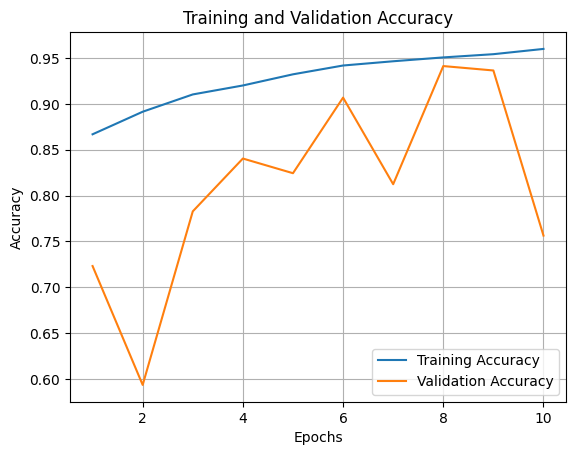

In [14]:
# Plot Accuracy
plt.figure()
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

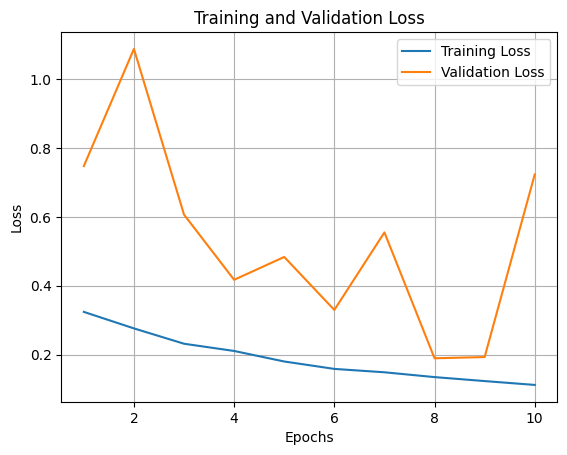

In [15]:
# Plot Loss
plt.figure()
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
model = tf.keras.models.load_model('best_model_2drop.h5')
test_ds = keras.utils.image_dataset_from_directory(
    directory = 'dataset/test',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(256, 256),
)

test_ds = test_ds.map(process)


Found 2504 files belonging to 3 classes.


Classification Report:
              precision    recall  f1-score   support

     general       0.88      0.91      0.89       786
     obscene       0.97      0.97      0.97       841
     violent       0.93      0.89      0.91       877

    accuracy                           0.93      2504
   macro avg       0.92      0.93      0.92      2504
weighted avg       0.93      0.93      0.93      2504



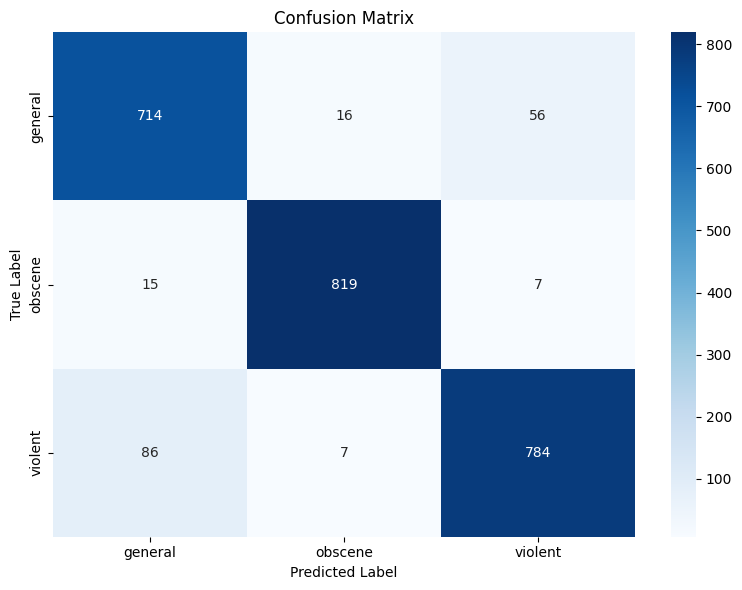

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

class_names = ['general', 'obscene', 'violent']

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=False)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [12]:
import cv2
import numpy as np
from PIL import Image
def predict_image(image):
    # Convert the PIL image to a format suitable for prediction
    img_rgb = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (256, 256))
    img_input = img_resized.reshape((1, 256, 256, 3))
    
    # Normalize the image
    img_input = img_input / 255.0

    # Predict
    prediction = model.predict(img_input)
    
    # Determine label and confidence
    return prediction
print(predict_image(Image.open(r'dataset\test\general\2.jpg')))

1/1 [==============================] - 0s 36ms/step
[[0.6703616  0.04246514 0.28717327]]
